# Measure distances, calculate the axis and map to cell space. 

### This notebook illustrates how to calculate relative distances and an OrganAxis while also transferring that information to cell segmentation data that is stored in a form of a table.
In this notebook, we will load our TissueTag annotated image of a IBEX protein multiplex imaging. 
Then we will translate the pixel level information to a an hexagonal grid space of a set spacing which we can use to measure the minimal euclidean distances between tissue compartments. 
Finally we will migrate annotations and measurements to single cell segmentation data by their xy position, print some plots and save the output as an annotated CSV table.

#### init and load image

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import tissue_tag as tt 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Part 1 - Load annotation names and colors 

In [ ]:
# set path
path_to_tissue_tag = ""
path = path_to_tissue_tag + '/data/tissue_tag_minimal_example_ibex/' 

In [ ]:
# load tissue annotations from TissueTag and migrate annotation to a 15um hexagonal grid and outputs the coordinates in ppm=1 
df_anno = tt.anno_to_grid(
    folder=path+'/tissue_annotations/',
    file_name = 'annotation_tissue',
    spot_to_spot = 15, # this determines the grid density in microns
    load_colors=True,
)
df_anno['annotation_tissue'].value_counts()

loaded annotation image - annotation_tissue size - (2704, 3948)
loaded annotations
{1: 'unassigned', 2: 'Artifacts', 3: 'Medulla', 4: 'Cortex', 5: 'Edge', 6: 'HS', 7: 'Vessels', 8: 'PVS', 9: 'Other'}
loaded ppm
{'ppm': 1}
loaded color annotations
{'unassigned': 'yellow', 'Artifacts': 'black', 'Medulla': 'green', 'Cortex': 'cyan', 'Edge': 'brown', 'HS': 'magenta', 'Vessels': 'blue', 'PVS': 'red', 'Other': 'orange'}
Generating grid with spot-to-spot distance - 15, with annotation resolution of - 1 ppm


annotation_tissue
unassigned    26396
Cortex        16842
Medulla        6606
Edge           3266
PVS             389
HS              293
Artifacts        87
Name: count, dtype: int64

# Part 2 - Calculate distances to structures and 2 versions of the axis

Here we calculate the relative distances of each spot in the grid to the closest corresponding K spots for each of the annotation categories. 

*note that here I selected K=10 to match the way we calculate the Cortico-Medullary axis for the thymus. However, since we have both broad (cortex,medulla) and fine grained (HS and PVS) structures in the same annotation. This might not be ideal for the fine grained structures. 

Ideally, you might prefer to have multiple annotation "layers" where you have broad and fine annotations separately as we have done in the paper and then select different K for each.   

In [4]:
print('calculating distances')
tt.dist2cluster_fast(
    df=df_anno,
    annotation='annotation_tissue',
    KNN=10
    ) # calculate minimum mean distance of each spot to clusters

calculating distances
calculating distance matrix with cKDTree
Artifacts
Cortex
Edge
HS
Medulla
PVS
unassigned


{'Artifacts': array([2319.27633003, 2304.42948403, 2289.5846345 , ..., 3524.1111708 ,
        3525.34958744, 3526.65136657]),
 'Cortex': array([1016.32800779, 1007.69089614,  998.93461616, ...,  580.22342817,
         594.49317111,  608.79790015]),
 'Edge': array([1076.34456691, 1066.23096309, 1056.15020776, ...,  550.34014721,
         564.60672388,  578.91028204]),
 'HS': array([1146.52005561, 1142.64433991, 1138.95199022, ...,  970.33979636,
         982.86209715,  995.45280367]),
 'Medulla': array([1039.80591586, 1033.69379448, 1027.69921951, ...,  870.34526389,
         882.52810319,  894.79640613]),
 'PVS': array([1628.41172251, 1613.54565715, 1598.68209299, ...,  918.30630609,
         930.3248121 ,  942.42881586]),
 'unassigned': array([26.10203332, 20.19615242, 19.79422863, ..., 19.79422863,
        19.79422863, 23.63340636])}

### Calculate morphological axes 

In [5]:
# axis calculations based on 3 landmarks  - this axis is good to capture the spatial variance across the entire thymus 
anno = 'annotation_tissue'
structure = ['Edge','Cortex','Medulla']
w = [0.2,0.8]
df_anno = tt.calculate_axis_3p(df_anno, anno=anno, structure=structure, output_col='cma_3p', w=w)

# axis calculations based on 2 landmarks - this axis is good to capture the location within the cortex
anno = 'annotation_tissue'
structure = ['Edge','Medulla']
df_anno = tt.calculate_axis_2p(df_anno, anno=anno, structure=structure, output_col='cma_2p')

In [6]:
# remove non-annotated spots this is better to do after axis calculations
df_anno = df_anno[df_anno['annotation_tissue']!='unassigned']
df_anno = df_anno[df_anno['annotation_tissue']!='Artifacts']


# Part 3 - map annotations to cells via spatial KNN and plot some outputs

In [7]:
# read cell coordinates from csv
df_cells = pd.read_csv(path+'sample_05_xy.csv')
ppm_cells = 3.5198

# correct coordinates to pixel space 
df_cells['y'] = df_cells['centroid-0']
df_cells['x'] = df_cells['centroid-1']

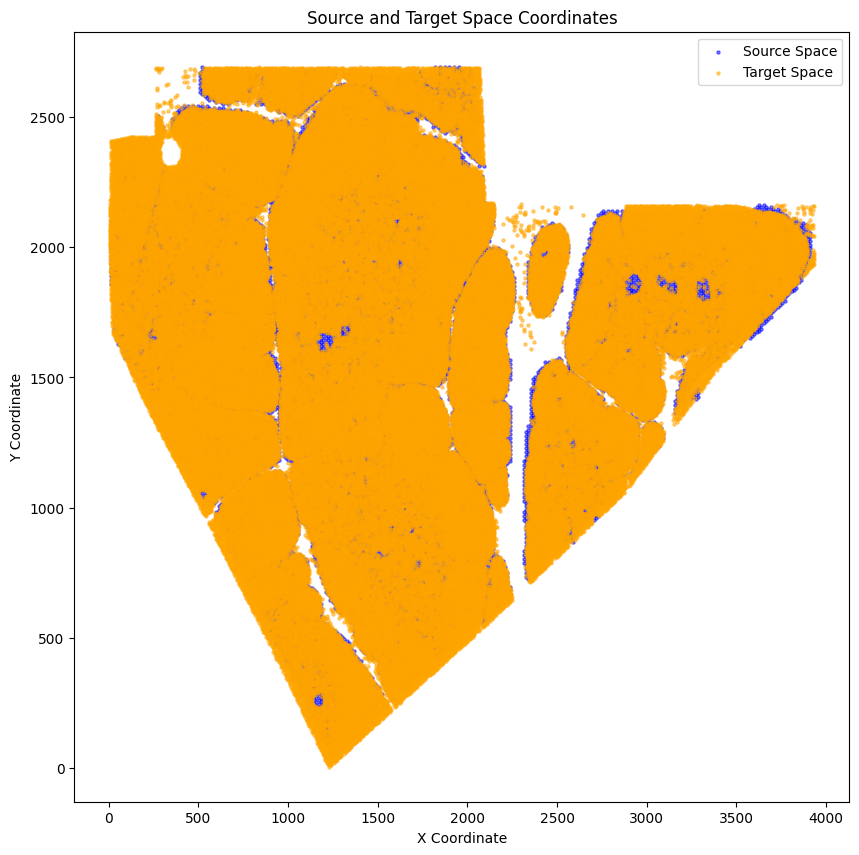

In [ ]:
# map the annotations to the cell space by nearest neighbor - make sure the 2 grids seem aligned
df_cells = tt.map_annotations_to_target(                                
    df_target=df_cells,  
    df_source=df_anno,
    ppm_target= ppm_cells,
    plot=True,
)

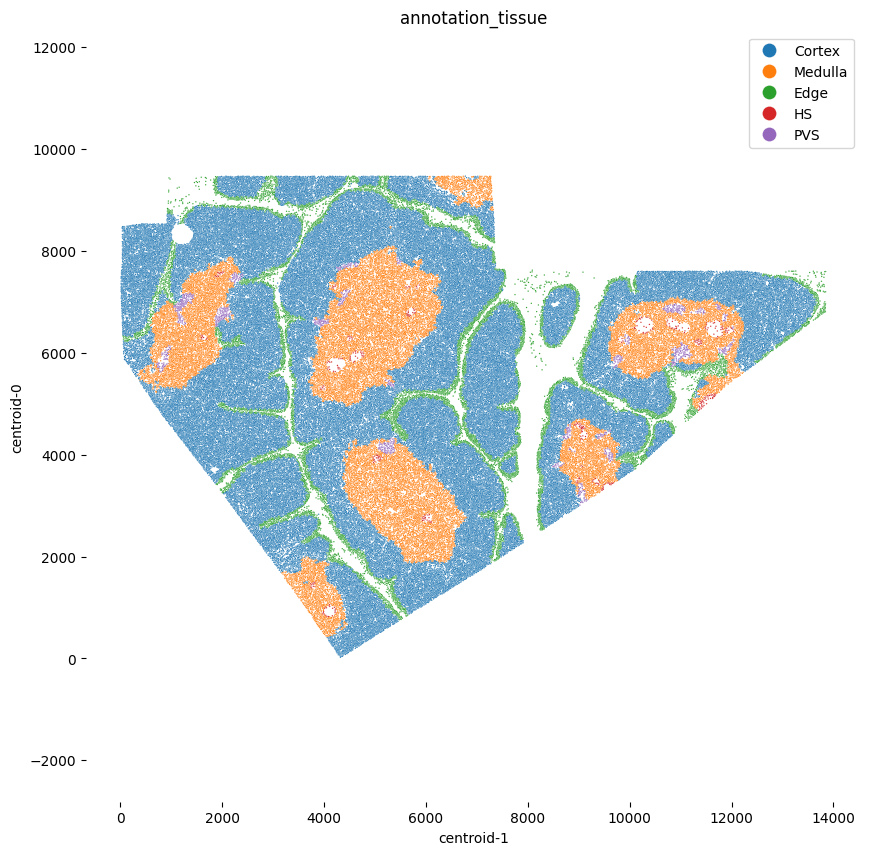

In [9]:
plt.figure(dpi=100, figsize=[10, 10])
sns.scatterplot(x='centroid-1', y='centroid-0', data=df_cells, hue='annotation_tissue', palette='tab10', s=1)
plt.title('annotation_tissue')
plt.axis('equal')
plt.grid(False)

# Hide the spines
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

# Increase the marker size in the legend
plt.legend(markerscale=10)  # Adjust this scale factor as needed

plt.show()


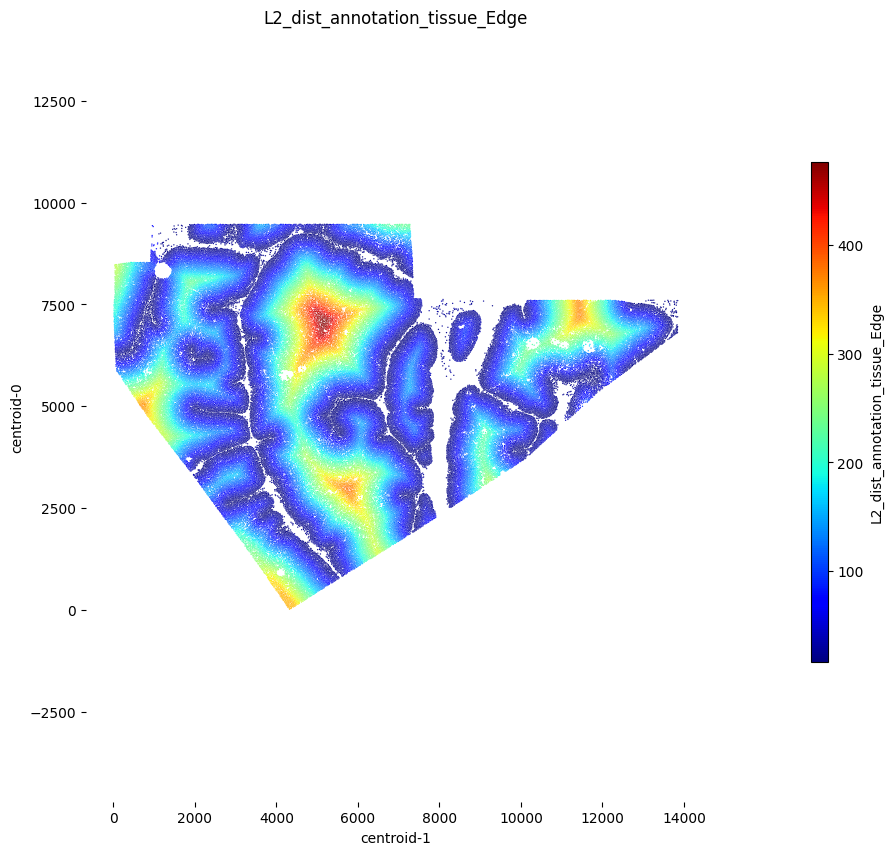

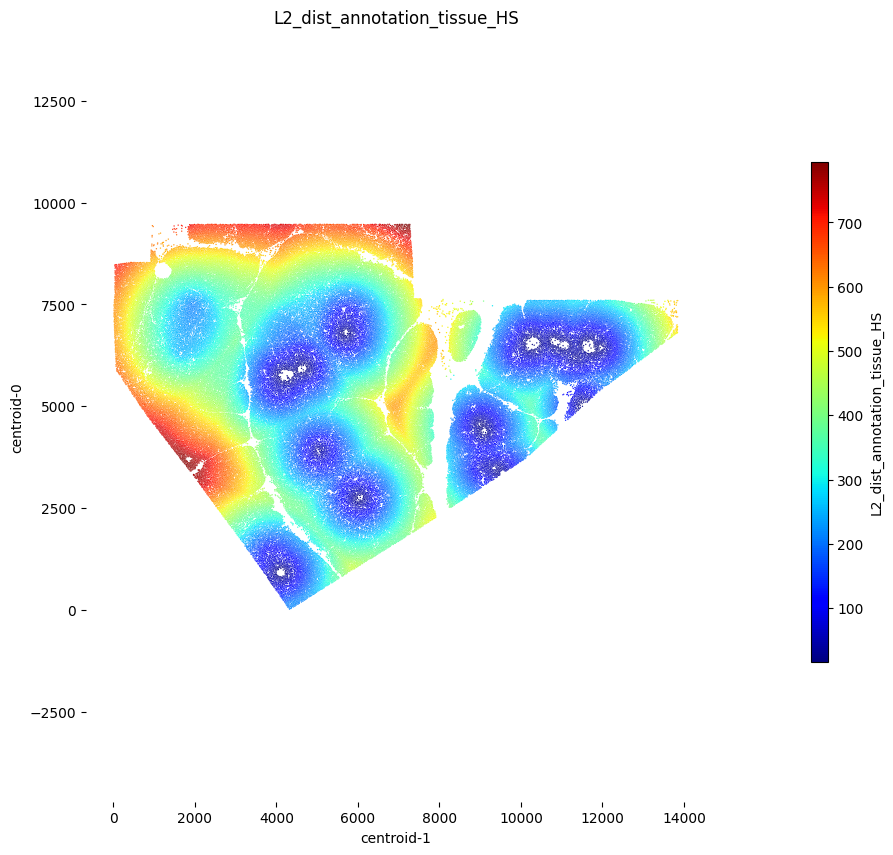

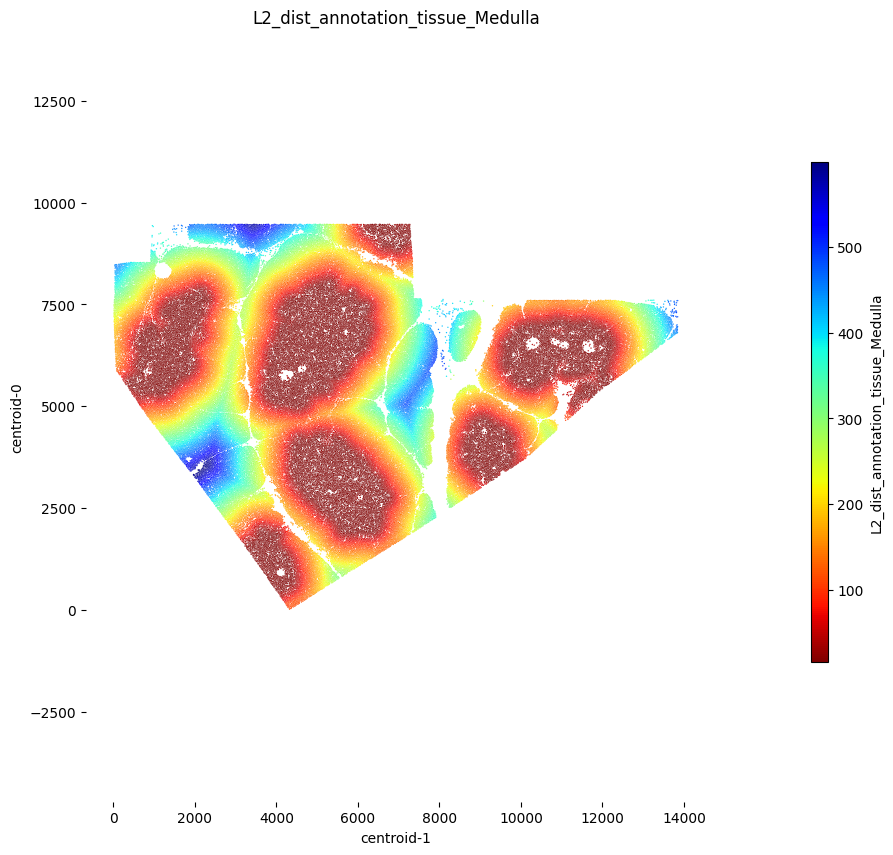

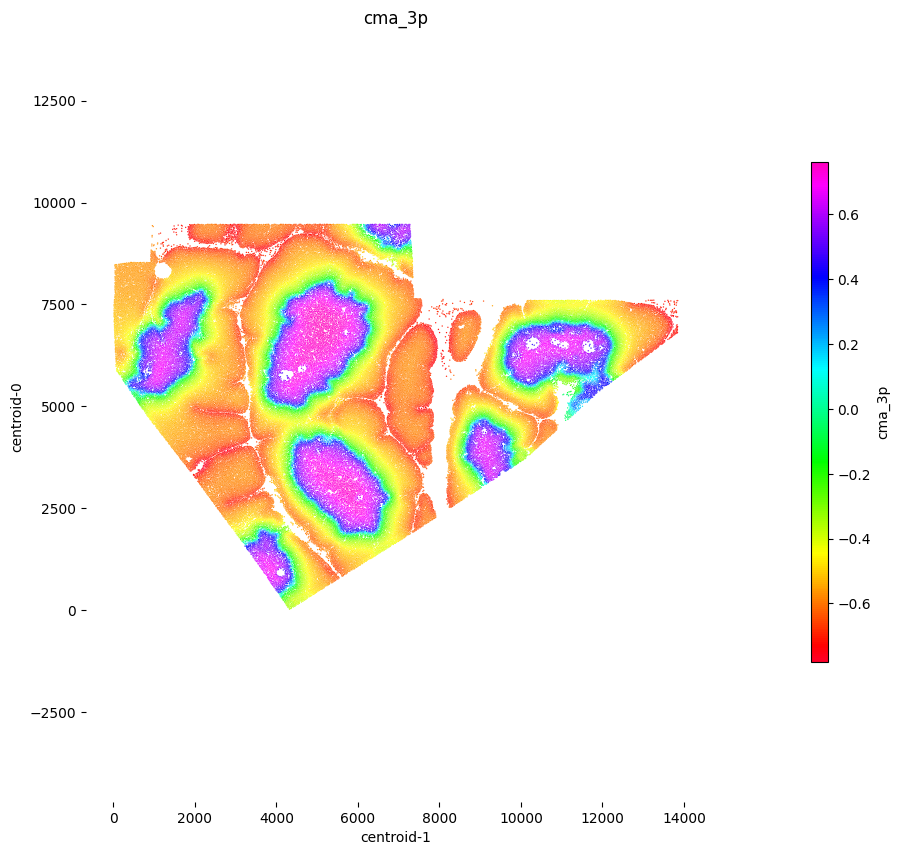

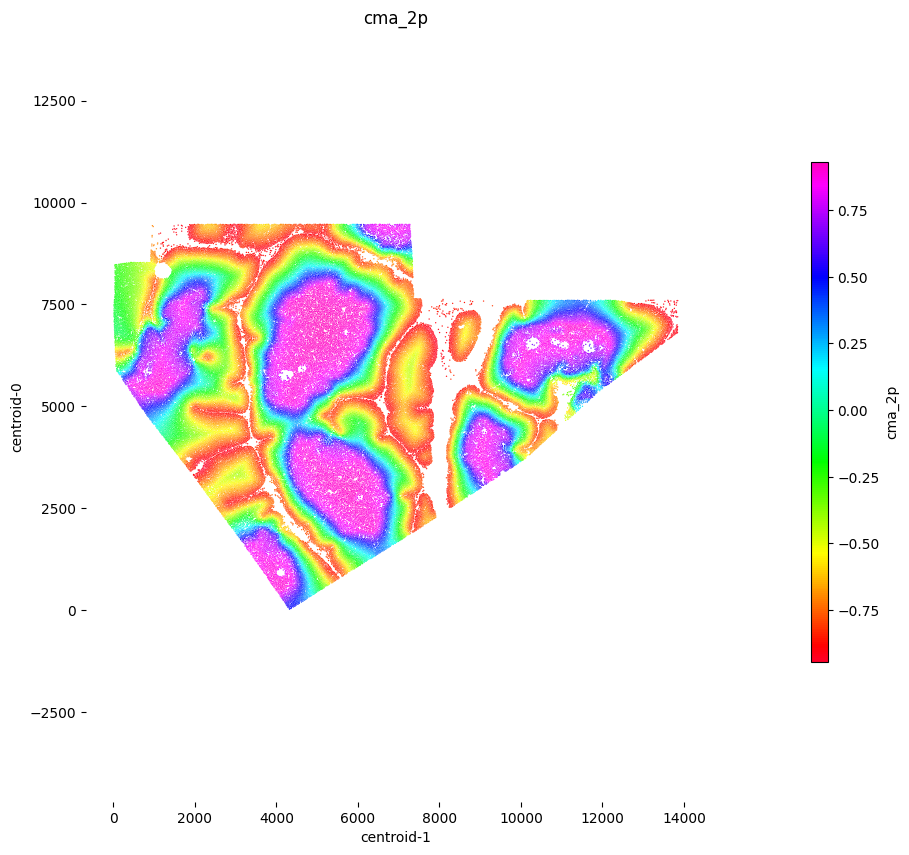

In [10]:
# plot the rest of the annotations
tt.plot_cont(df_cells, x_col='centroid-1', y_col='centroid-0', color_col='L2_dist_annotation_tissue_Edge', cmap='jet', title='L2_dist_annotation_tissue_Edge', s=1, dpi=100, figsize=[10,10])
tt.plot_cont(df_cells, x_col='centroid-1', y_col='centroid-0', color_col='L2_dist_annotation_tissue_HS', cmap='jet', title='L2_dist_annotation_tissue_HS', s=1, dpi=100, figsize=[10,10])
tt.plot_cont(df_cells, x_col='centroid-1', y_col='centroid-0', color_col='L2_dist_annotation_tissue_Medulla', cmap='jet_r', title='L2_dist_annotation_tissue_Medulla', s=1, dpi=100, figsize=[10,10])
tt.plot_cont(df_cells, x_col='centroid-1', y_col='centroid-0', color_col='cma_3p', cmap='gist_rainbow', title='cma_3p', s=1, dpi=100, figsize=[10,10])
tt.plot_cont(df_cells, x_col='centroid-1', y_col='centroid-0', color_col='cma_2p', cmap='gist_rainbow', title='cma_2p', s=1, dpi=100, figsize=[10,10])
